#Imports

In [ ]:
!pip install datasets
import datasets
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from datasets import list_datasets
from datasets import load_dataset

!pip install librosa
import librosa
import librosa.display

!pip install transformers

!pip install tqdm
from tqdm import tqdm as load_bar

!pip install torchaudio
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

!pip install nnAudio==0.3.1
import nnAudio
from nnAudio.features.mel import MelSpectrogram
from nnAudio.features.mel import MFCC

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.cuda import amp
import torchvision
from torchsummary import summary
from google.colab import drive

import numpy as np
import shutil
import pickle
import copy
import gc
from random import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio, display
import random
from random import randint
import matplotlib.pyplot as plt
from collections import defaultdict
import time as timing
from google.colab import drive
from google.colab import files


In [ ]:
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

print(device)

cuda:0


#Functions

In [ ]:
def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

In [ ]:
def fix_audio(audio):
  audio = audio.to(device)
  len_audio = audio.size(1)

  if len_audio < SR:
      # Pad with zeros
      audio = torch.nn.functional.pad(audio, (0, SR - len_audio), 'constant', 0)
  elif len_audio > SR:
      # Random crop
      start = random.randint(0, len_audio - SR)
      audio = audio[:, start:start + SR]

  return audio

In [ ]:
def fit_and_eval(net, epochs, optimizer, criterion, num_classes,
                 train_data_loader, validation_data_loader, device,
                 validation_step = False):

  dict_hist = {
      'Train_acc' : [],
      'Train_loss' : [],
      'Valid_acc' : [],
      'Valid_loss': [],
      'Time_train': []
  }

  for epoch in load_bar(range(epochs)):
      net.train()
      print("Epoch {}:".format(epoch+1))

      # ------------- TRAIN SET ----------- #
      train_loss = 0.
      train_acc = 0.
      train_samples = 0

      time_train_batch = timing.time()

      for img, label in train_data_loader:
          optimizer.zero_grad()

          #label = label.view(-1, 1)
          #label = label.float()
          label = label.to(device)


          #img = img.squeeze(dim=2)

          out_fr = net(img)
          loss = criterion(out_fr, label)

          loss.backward()
          optimizer.step()

          train_samples += label.numel()
          train_loss += loss.item() * label.numel()
          train_acc += (out_fr.argmax(1) == label).float().sum().item()

      time_end_batch = timing.time()

      train_loss /= train_samples
      train_acc /= train_samples

      dict_hist['Train_acc'].append(train_acc)
      dict_hist['Train_loss'].append(train_loss)
      dict_hist['Time_train'].append(time_end_batch - time_train_batch)


      # ------------- VALIDATION ----------- #
      if(validation_step == True):
        net.eval()
        val_loss = 0.
        val_acc = 0.
        val_samples = 0

        with torch.no_grad():
            for img, label in validation_data_loader:
                #label = label.view(-1, 1)
                #label = label.float()
                label = label.to(device)

                #img = img.squeeze(dim=2)

                out_fr = net(img)
                loss = criterion(out_fr, label)

                val_samples += label.numel()
                val_loss += loss.item() * label.numel()
                val_acc += (out_fr.argmax(1) == label).float().sum().item()


        val_loss /= val_samples
        val_acc /= val_samples

        dict_hist['Valid_acc'].append(val_acc)
        dict_hist['Valid_loss'].append(val_loss)


      if(validation_step == True):
        print("\nB train acc: {:.4f} -- B train Loss: {:.4f} ## B valid acc: {:.4f} -- B valid loss: {:.4f}  ## Time: {:.2f}".format(train_acc, train_loss, val_acc, val_loss, (time_end_batch - time_train_batch)))
      else:
        print("\nB train acc: {:.4f} -- B train Loss: {:.4f} ## Time: {:.2f}".format(train_acc, train_loss, (time_end_batch - time_train_batch)))

  return dict_hist

In [ ]:
# Define a function to run inference on the test set
def test(model, device, test_loader):

    dict_hist = {
      'Time_test': [],
      'Acc_test': []
    }

    model.eval()

    time_start = timing.time()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in load_bar(test_loader):
            img, labels = data
            img  = img.to(device)
            labels = labels.to(device)

            out = model(img)

            _, predicted = torch.max(out, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        time_end = timing.time()
        acc = 100 * correct / total
        print('Test set accuracy: {:.2f}%'.format(acc))

        dict_hist['Acc_test'].append(acc)
        dict_hist['Time_test'].append(time_end - time_start)

    return dict_hist

In [ ]:
def load_weights (path, model):

  with open(path, "rb") as f:
    w = pickle.load(f)

  if isinstance(w, dict):
    print(w.keys())
    return w
  else:
    print("--- Not a dict, try to load weights in model ---")
    try: model.load_state_dict(w)
    except: print(("Something went wrong"))


In [ ]:
def random_noise_list(n_times, size, label=1, random_silence=True):
  out = []

  for i in range(n_times):
    start = torch.randn(size)

    if random_silence:
      if torch.empty(1).uniform_(0, 1) > 0.3:
        random_length = random.randint(1, SR)

        # Define the starting index of the random part
        random_start = random.randint(0, start.size(1) - random_length)

        # Set the random part to zeros
        start[:, random_start:random_start + random_length] = 0

    out.append( (start, label) )

  return out


In [ ]:
def plot_melspectrogram(specgram, title=None, ylabel="freq_bin"):

    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def waveform_spectrogram_plot(waveform):
    # Define the transform for generating spectrograms
    transform = torchaudio.transforms.Spectrogram()

    # Generate spectrogram
    spectrogram = transform(waveform)

    # Plot the spectrogram
    plt.figure(figsize=(8, 6))
    plt.imshow(spectrogram[0].log1p(), aspect='auto', origin='lower')
    plt.title("Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_history(dict_hist):

  plt.plot(dict_hist['Train_acc'])
  plt.plot(dict_hist['Valid_acc'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()


  plt.plot(dict_hist['Train_loss'])
  plt.plot(dict_hist['Valid_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

In [ ]:
def play_audio(audio_vector):
    audio_array = audio_vector.squeeze().detach().cpu().numpy()  # Convert to a 1D numpy array
    return Audio(data=audio_array, rate=16000)

In [ ]:
def dict_to_pickle(path, data):

  with open(path, 'wb') as f:
      pickle.dump(data, f)

In [ ]:
def ndarray_to_wav(ndarray, sr=16000, path="audio.wav", display=False):

  scaled = np.int16(ndarray / np.max(np.abs(ndarray)) * 32767)
  write(path, sr, scaled)

  if display:
    display(Audio(path, autoplay=False))

  return scaled

In [ ]:
from torchvision.models import vgg19_bn, resnet50, mobilenet_v2

def setup_other_models(model_name, pretrained=True ):

    new_start_layer = nn.Conv2d(1, 3, kernel_size=1)

    if "vgg" in model_name:
      if pretrained:
        model = vgg19_bn(weights='VGG19_BN_Weights.IMAGENET1K_V1')
      else:
        model = vgg19_bn(weights=None)

      model.features = nn.Sequential(new_start_layer, *model.features)

      vgg_classifier_fin = nn.Sequential(
          nn.Linear(in_features=25088, out_features=1024, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(in_features=1024, out_features=256, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(256, N_CLASSES_SPEECH))

      model.classifier = vgg_classifier_fin



    if "resnet" in model_name:
      if pretrained:
        model = resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
      else:
        model = resnet50(weights=None)

      model.conv1 = nn.Sequential(new_start_layer, model.conv1)

      resnext_classifier = nn.Sequential(
          nn.Linear(in_features=2048, out_features=1024, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(in_features=1024, out_features=256, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(256, N_CLASSES_SPEECH))

      model.fc = resnext_classifier



    if "mobile" in model_name:
      if pretrained:
        model = mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
      else:
        model = mobilenet_v2(weights=None)

      model.features = nn.Sequential(new_start_layer, *model.features)

      mobile_classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(512, 256),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),

          nn.Linear(256, N_CLASSES_SPEECH))

      model.classifier = mobile_classifier


    return model.to(device)



#Datasets

In [ ]:
SR = 16000

## Digits

In [ ]:
N_CLASSES_DIGITS = 10

In [ ]:
import os
import urllib.request
import tarfile

def download_and_extract(url, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    filename = os.path.basename(url)
    file_path = os.path.join(target_folder, filename)

    print("Downloading {}...".format(filename))
    urllib.request.urlretrieve(url, file_path)

    print("Extracting {}...".format(filename))
    with tarfile.open(file_path, 'r') as tar_ref:
        tar_ref.extractall(target_folder)

    print("Dataset downloaded and extracted successfully!")

# Set the download URL and target folder
url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
!mkdir /content/digits
target_folder = "/content/digits"

# Download and extract the dataset
download_and_extract(url, target_folder)

Extracting v1.0.9.tar.gz...
Dataset downloaded and extracted successfully!


In [ ]:
import os
import random
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class DigitsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_path = self.file_list[index]
        waveform, sample_rate = torchaudio.load(file_path)

        resampler = torchaudio.transforms.Resample(sample_rate, SR)
        waveform = resampler(waveform)

        if waveform.size(1) < SR:
            waveform = torch.nn.functional.pad(waveform, (0, SR - waveform.size(1)), 'constant', 0)

        elif waveform.size(1) > SR:
            start = random.randint(0, waveform.size(1) - SR)
            waveform = waveform[:, start:start + SR]


        if self.transform is not None:
            waveform = self.transform(waveform)

        label = int(os.path.basename(file_path)[0])
        waveform = waveform.to(device)  # Extract the digit label from the filename

        return waveform, label

In [ ]:
# Set the path to the dataset directory
data_dir = "/content/digits/free-spoken-digit-dataset-1.0.9/recordings"


# Load file list
file_list = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            file_list.append(os.path.join(root, file))
file_list.sort()  # Sort the file list alphabetically

test_ratio = 0.1
val_ratio = 0.2

train_digit_files, test_digit_files = train_test_split(file_list, test_size=test_ratio, shuffle=True)
train_digit_files, val_digit_files = train_test_split(train_digit_files, test_size=val_ratio/(1-test_ratio), shuffle=True)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SR,
    n_fft = 2048,
    hop_length = 512,
    n_mels = 128
)

In [ ]:

# Create dataset instances for train, validation, and test sets
train_digit_dataset = DigitsDataset(train_digit_files, transform=None)
val_digit_dataset = DigitsDataset(val_digit_files, transform=None)
test_digit_dataset = DigitsDataset(test_digit_files, transform=None)

# Create dataloaders
batch_size = 64
train_digit_dataloader = DataLoader(train_digit_dataset, batch_size=batch_size, shuffle=True)
val_digit_dataloader = DataLoader(val_digit_dataset, batch_size=batch_size, shuffle=True)
test_digit_dataloader= DataLoader(test_digit_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_digit_dataset[0][0].size(), train_digit_dataset[0][1], type(train_digit_dataset[0][1]))

torch.Size([1, 128, 32]) 0 <class 'int'>


## SpeechCommands

In [ ]:
N_CLASSES_SPEECH = 35

In [ ]:
# Load the SpeechCommands dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS("/content", download=True)

100%|██████████| 2.26G/2.26G [00:32<00:00, 74.0MB/s]


In [ ]:
# Create a dictionary to map labels to integer values
label2int = defaultdict(lambda: len(label2int))

# Map each label to an integer value
for _, _, label, _, _ in dataset:
    label2int[label]

# Print the mapping
print(label2int)

defaultdict(<function <lambda> at 0x7a7e18bdc0d0>, {'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34})


In [ ]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, root, subset, transformations=None, device="cuda:0", whole=True):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(root, subset=subset, download=False)
        self.device = device
        self.whole = whole

        self.transformations = transformations

    def __getitem__(self, idx):
        audio, _, label, _, _ = self.dataset[idx]

        audio = audio.mean(dim=0, keepdim=True)  # Convert the audio to mono
        audio = audio.to(self.device)

        if not self.whole:
          audio = fix_audio(audio)

        if self.transformations is not None:
            audio = self.transformations(audio)

            audio = NormalizeTensor(audio)

        return audio, label2int[label]

    def __len__(self):
        return len(self.dataset)


In [ ]:
train = torchaudio.datasets.SPEECHCOMMANDS("/content", subset="training", download=False)
train_split = SpeechCommandsDataset("/content", subset="training", transformations = None, device=device, whole=False)

In [ ]:
noise_dish, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav")
noise_miaow, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/dude_miaowing.wav")
noise_bike, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/exercise_bike.wav")
noise_pink, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/pink_noise.wav")
noise_running, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/running_tap.wav")
noise_white, _ = torchaudio.load("/content/SpeechCommands/speech_commands_v0.02/_background_noise_/white_noise.wav")


NOISES = [noise_dish, noise_miaow, noise_bike, noise_pink, noise_running, noise_white]

In [ ]:
import math
size = math.floor(len(train) * 0.3)

idxs = random.sample(range(1, len(train)), size)

additional_train = []
for idx in idxs:
    waveform, label = train_split[idx]

    idx_noise = random.randint(0, len(NOISES)-1)
    noise = fix_audio(NOISES[idx_noise])
    noisy_wave = noise + waveform

    additional_train.append((noisy_wave, label))


In [ ]:
# Convert the additional samples to a dataset
additional_waveforms, additional_labels = zip(*additional_train)
additional_waveforms = torch.stack(additional_waveforms)
additional_waveforms = additional_waveforms.to(device)
additional_labels = torch.tensor(additional_labels, device = device)

additional_train = torch.utils.data.TensorDataset(additional_waveforms, additional_labels)

In [ ]:
class AugmentSpeech(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset


    def __getitem__(self, idx):
        audio, label = self.dataset[idx]

        return audio, label.item()

    def __len__(self):
        return len(self.dataset)


additional_data = AugmentSpeech(additional_train)

In [ ]:
batch_size = 128

augment_train = torch.utils.data.ConcatDataset([train_split, additional_data])
augment_train_loader = DataLoader(augment_train, batch_size, shuffle=True)

In [ ]:
class SpeechCommandsDataset_wav2vec(Dataset):
    def __init__(self, root, subset, transformation, device = "cuda:0"):
        self.dataset = SPEECHCOMMANDS(root, subset=subset, download = False)
        self.device = device
        self.transformation = transformation



    def __getitem__(self, idx):
        audio, _, label, _, _ = self.dataset[idx]
        audio = audio.to(self.device)
        len_audio = audio.size(1)

        if len_audio < SR:
            # pad with zeros
            audio = torch.nn.functional.pad(audio, (0, SR - len_audio), 'constant', 0)
        elif len_audio > SR:
            # random crop
            start = random.randint(0, len_audio - SR)
            audio = audio[start:start + SR]

        if (self.transformation is not None):
          if (self.transformation == "processor"):
            input_features = processor(audio, sampling_rate=SR, return_tensors="pt")

            return {
              'input_features': input_features.input_values.squeeze(1),
              'label': torch.tensor(label2int[label]).to(device)}

          else:
            audio = self.transformation(audio)

        return audio, label2int[label]

    def __len__(self):
        return len(self.dataset)

In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SR,
    n_fft = 2048,
    hop_length = 512,
    n_mels = 128
).to(device)


In [ ]:
train_split = SpeechCommandsDataset("/content", subset="training", transformations = None, device=device, whole=False)
val_split = SpeechCommandsDataset("/content", subset="validation", transformations = None, device=device, whole=False)
test_split = SpeechCommandsDataset("/content", subset="testing", transformations = None, device=device, whole=False)

In [ ]:
batch_size = 128

train_loader = DataLoader(train_split, batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size, shuffle=True)
test_loader = DataLoader(test_split, batch_size, shuffle=True)

### EDA SpeechDataset

In [ ]:
full_speech = SpeechCommandsDataset("/content", subset=None, transformations = None, device=device, whole=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_audio_lengths(dataset):

    lengths = []

    for item in dataset:
      audio, label = item
      lengths.append(len(audio))  # Convert to seconds

    mean_length = np.mean(lengths)
    std_length = np.std(lengths)

    min_length = np.min(lengths)
    max_length = np.max(lengths)


    # Plotting the distribution
    plt.hist(lengths, bins=20, edgecolor='black')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Audio Lengths')
    plt.grid(True)
    plt.show()

    # Print mean and standard deviation
    print("Mean Length: {:.2f} seconds".format(mean_length))
    print("Standard Deviation: {:.2f} seconds".format(std_length))

    print("Shortest Audio: {:.2f} seconds".format(min_length))
    print("Longest Audio: {:.2f} seconds".format(max_length))


In [ ]:
plot_audio_lengths(full_speech)

#Custom Modules

In [ ]:
class ConvReluPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, mode="avg"):
    super().__init__()

    layers = []

    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
    layers.append(nn.ReLU())
    if mode=="avg":
      layers.append(nn.AvgPool2d((2,2)))
    elif mode=="max":
      layers.append(nn.MaxPool2d((2,2)))

    self.block = nn.Sequential(*layers)


  def forward(self, x):
    return self.block(x)


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()

        # Squeeze: apply global average pooling across spatial dimensions
        out = self.avg_pool(x).view(batch_size, channels)

        # Excite: learn the channel-wise weights using fully connected layers
        out = self.fc1(out)
        out = torch.nn.functional.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        # Scale: apply the learned channel-wise weights to the input
        out = out.view(batch_size, channels, 1, 1)
        out = x * out.expand_as(x)
        return out


In [ ]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.channels = in_channels

        self.fc = nn.Sequential(nn.Conv2d(self.channels, self.channels // reduction_ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(self.channels // reduction_ratio, self.channels, 1, bias=False))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        a = self.avg_pool(x)
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))

        out = avg_out + max_out

        return self.sigmoid(out)



class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)



class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channels = in_channels
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x_out = self.channel_attention(x) * x
        x_out = self.spatial_attention(x_out) * x_out
        return x_out


In [ ]:
class InvertedResidualBlock_new(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, expand_ratio=6):
        super(InvertedResidualBlock_new, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels
        self.kernel = kernel_size

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False, groups=in_channels))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))

        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=self.kernel, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [ ]:
class DepthwisePointwiseConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(DepthwisePointwiseConv1D, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, stride=stride)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):

        # Apply depthwise convolution
        x = self.depthwise_conv(x)

        # Apply pointwise convolution
        x = self.pointwise_conv(x)

        return x

#FINAL NET - APAC

In [ ]:
from torchvision.models.efficientnet import InterpolationMode
from torchvision.transforms.functional import resize

class Cass_4_GOLD_colabV3(nn.Module):
    def __init__(self, sr, n_classes):
        super().__init__()

        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        self.relu6 = nn.ReLU6()

        self.maxpool = nn.MaxPool2d((2,2))
        self.maxpool_2 = nn.MaxPool2d((1,2))
        self.avgpool = nn.AvgPool2d((2,2))

        self.flatten = nn.Flatten()


        #### START ####

        self.spectrogram = MelSpectrogram(sr=sr, trainable_mel=True, trainable_STFT=False).to(device)
        self.mfcc = MFCC(sr=sr, n_mfcc=64).to(device)


        # ---------- SMALL ----------- #
        self.conv_s1 = DepthwisePointwiseConv1D(1, 16, 3, padding=1)
        self.conv_s3 = DepthwisePointwiseConv1D(16, 32, 3, padding=1)
        # -> pool
        self.inv_s1 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=1, expand_ratio=4)
        self.conv_s4 = DepthwisePointwiseConv1D(32, 64, 3, padding=1)
        # -> pool
        self.inv_s2 = InvertedResidualBlock_new(in_channels=64, out_channels=64, stride=1, expand_ratio=4)
        self.conv_s5 = DepthwisePointwiseConv1D(64, 64, 3, padding=1)
        self.se_s2 = SEBlock(in_channels=64, reduction_ratio = 16)
        self.cbam_s2 = CBAM(in_channels=64, reduction_ratio = 16, kernel_size=3)
        self.conv_s6 = DepthwisePointwiseConv1D(64, 128, 3, padding="same")
        self.inv_s4 = InvertedResidualBlock_new(in_channels=128, out_channels=128, stride=1, expand_ratio=4)
        self.layer_norm_s = nn.LayerNorm([128,8,2])



        # ---------- LARGE ----------- #
        self.conv_l1 = DepthwisePointwiseConv1D(1, 8, 7, padding="same")
        # -> pool
        self.inv_l1 = InvertedResidualBlock_new(in_channels=8, out_channels=8, stride=1, expand_ratio=4)
        self.conv_l2 = DepthwisePointwiseConv1D(8, 16, 7, padding="same")
        # -> pool
        self.inv_l2 = InvertedResidualBlock_new(in_channels=16, out_channels=16, stride=2, expand_ratio=4)
        self.conv_l3 = DepthwisePointwiseConv1D(16, 32, 7, padding="same")
        self.se_l1 = SEBlock(in_channels=32, reduction_ratio = 16)
        self.cbam_l1 = CBAM(in_channels=32, reduction_ratio = 16, kernel_size=7)
        self.inv_l3 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=1, expand_ratio=4)
        # -> pool
        self.layer_norm_l = nn.LayerNorm([32,8,2])


        # ---------- MIXED ---------------- #
        self.conv_m1 = nn.Conv2d(160, 128, 1, groups=32)
        self.inv_m1 = InvertedResidualBlock_new(in_channels=128, out_channels=128, stride=1, expand_ratio=4)
        self.se_m1 = SEBlock(in_channels=128, reduction_ratio = 16)
        self.cbam_m1 = CBAM(in_channels=128, reduction_ratio = 16, kernel_size=7)


        # ---------- MFCC ----------- #
        self.conv_mfcc = DepthwisePointwiseConv1D(1, 16, 3, padding=1)
        self.conv_r1 = DepthwisePointwiseConv1D(16, 32, 3, padding=1)
        # -> pool
        self.se_r1 = SEBlock(in_channels=32, reduction_ratio=16)
        self.conv_r3 = DepthwisePointwiseConv1D(32, 32, 3, padding="same")
        self.inv_r1 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=2, expand_ratio=4)


        # ----------- LAST --------------- #
        self.cbam_fin = CBAM(in_channels=160, reduction_ratio = 32, kernel_size=3)
        self.conv_cat1 = nn.Conv2d(160, 128, (3,1))




        # ---------- CLASSIFIER ----------- #
        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.Dropout(0.7),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),

            nn.Linear(64, n_classes))



    def forward(self, x):

        start_ = self.spectrogram(x) #128x32
        start = start_.unsqueeze(1)

        mfcc = self.mfcc(x)

        x_s = self.gelu(self.conv_s1(start))
        x_s = self.conv_s3(x_s)
        x_s = self.maxpool(x_s)
        x_s = self.inv_s1(x_s)
        x_s = self.gelu(self.conv_s4(x_s))
        x_s = self.maxpool(x_s)
        x_s = self.inv_s2(x_s)
        x_s = self.gelu(self.conv_s5(x_s))
        x_s = self.se_s2(x_s)
        x_s = self.cbam_s2(x_s)
        x_s = self.maxpool(self.gelu(self.conv_s6(x_s)))
        x_s = self.maxpool(self.inv_s4(x_s))

        x_l = self.gelu(self.conv_l1(start))
        x_l = self.maxpool(x_l)
        x_l = self.gelu(self.inv_l1(x_l))
        x_l = self.conv_l2(x_l)
        x_l = self.maxpool(x_l)
        x_l = self.gelu(self.inv_l2(x_l))
        x_l = self.conv_l3(x_l)
        x_l = self.se_l1(x_l)
        x_l = self.cbam_l1(x_l)
        x_l = self.gelu(self.inv_l3(x_l))
        x_l = self.maxpool(x_l)

        #print(x_s.shape, x_l.shape) #Torch.Size([128, 128, 8, 2]) torch.Size([128, 32, 8, 2])


        x_l = self.layer_norm_l(x_l)
        x_s = self.layer_norm_s(x_s)

        x_sl = torch.cat([x_s, x_l], dim=1) #192x16x4
        #print(x_sl.shape) #torch.Size([2, 160, 8, 2])

        x_sl = self.gelu(self.conv_m1(x_sl))
        x_sl = self.inv_m1(x_sl)
        x_sl = self.se_m1(x_sl)
        x_sl = self.cbam_m1(x_sl)
        #print(x_sl.shape) #torch.Size([2, 64, 8, 2])


        mfcc = self.conv_mfcc(mfcc.unsqueeze(1))
        mfcc = self.gelu(self.conv_r1(mfcc))
        mfcc = self.maxpool(mfcc)
        mfcc = self.se_r1(mfcc)
        mfcc = self.gelu(self.conv_r3(mfcc))
        mfcc = self.inv_r1(mfcc)
        mfcc = self.maxpool(mfcc)
        mfcc = self.maxpool_2(mfcc)
        #print(mfcc.shape) #torch.Size([2, 32, 8, 2])



        cat = torch.cat([x_sl, mfcc], dim=1)
        #print(cat.shape) #torch.Size([128, 160, 8, 2])
        cat = self.cbam_fin(cat)
        cat = self.gelu(self.conv_cat1(cat))
        cat = self.maxpool(cat)
        #print(cat.shape)


        fl = self.flatten(cat)
        #print(fl.shape)
        #fl = self.flatten(x_sl)
        #print(fl.shape) #1024

        out = self.classifier(fl)

        return out


In [ ]:
cass_4_GOLD_colabV3 = Cass_4_GOLD_colabV3(SR, 35).to(device)
summary(cass_4_GOLD_colabV3, (1,16000))

#B train acc: 0.8857 -- B train Loss: 0.4498 ## B valid acc: 0.9072 -- B valid loss: 0.3436  ## Time: 105.11 e80 - STFT + MEl train

#B train acc: 0.8797 -- B train Loss: 0.4656 ## B valid acc: 0.8791 -- B valid loss: 0.4278  ## Time: 126.27 - STFT trainable

STFT kernels created, time used = 0.2228 seconds
STFT filter created, time used = 0.0033 seconds
Mel filter created, time used = 0.0034 seconds
STFT kernels created, time used = 0.1101 seconds
STFT filter created, time used = 0.0045 seconds
Mel filter created, time used = 0.0051 seconds
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              STFT-1             [-1, 1025, 32]               0
    MelSpectrogram-2              [-1, 128, 32]               0
              STFT-3             [-1, 1025, 32]               0
    MelSpectrogram-4              [-1, 128, 32]               0
              MFCC-5               [-1, 64, 32]               0
            Conv2d-6           [-1, 1, 128, 32]              10
            Conv2d-7          [-1, 16, 128, 32]              32
DepthwisePointwiseConv1D-8          [-1, 16, 128, 32]               0
              GELU-9          [-1, 16, 128, 32]               0
 

In [ ]:
from torchvision.models.efficientnet import InterpolationMode
from torchvision.transforms.functional import resize

#THE SAME AS THE STANDARD NET BUT WITHOUT THE NNAUDIO TRAINABLE LAYER -> classical torchaudio -> requires audio already in spectrogram

class Cass_4_GOLD_colabV3n(nn.Module):
    def __init__(self, sr, n_classes, mel_spectrogram, mfcc):
        super().__init__()

        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        self.relu6 = nn.ReLU6()

        self.maxpool = nn.MaxPool2d((2,2))
        self.maxpool_2 = nn.MaxPool2d((1,2))
        self.avgpool = nn.AvgPool2d((2,2))

        self.flatten = nn.Flatten()


        #### START ####
        self.m = mel_spectrogram
        self.mf = mfcc


        # ---------- SMALL ----------- #
        self.conv_s1 = DepthwisePointwiseConv1D(1, 16, 3, padding=1)
        self.conv_s3 = DepthwisePointwiseConv1D(16, 32, 3, padding=1)
        # -> pool
        self.inv_s1 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=1, expand_ratio=4)
        self.conv_s4 = DepthwisePointwiseConv1D(32, 64, 3, padding=1)
        # -> pool
        self.inv_s2 = InvertedResidualBlock_new(in_channels=64, out_channels=64, stride=1, expand_ratio=4)
        self.conv_s5 = DepthwisePointwiseConv1D(64, 64, 3, padding=1)
        self.se_s2 = SEBlock(in_channels=64, reduction_ratio = 16)
        self.cbam_s2 = CBAM(in_channels=64, reduction_ratio = 16, kernel_size=3)
        self.conv_s6 = DepthwisePointwiseConv1D(64, 128, 3, padding="same")
        self.inv_s4 = InvertedResidualBlock_new(in_channels=128, out_channels=128, stride=1, expand_ratio=4)
        self.layer_norm_s = nn.LayerNorm([128,8,2])



        # ---------- LARGE ----------- #
        self.conv_l1 = DepthwisePointwiseConv1D(1, 8, 7, padding="same")
        # -> pool
        self.inv_l1 = InvertedResidualBlock_new(in_channels=8, out_channels=8, stride=1, expand_ratio=4)
        self.conv_l2 = DepthwisePointwiseConv1D(8, 16, 7, padding="same")
        # -> pool
        self.inv_l2 = InvertedResidualBlock_new(in_channels=16, out_channels=16, stride=2, expand_ratio=4)
        self.conv_l3 = DepthwisePointwiseConv1D(16, 32, 7, padding="same")
        self.se_l1 = SEBlock(in_channels=32, reduction_ratio = 16)
        self.cbam_l1 = CBAM(in_channels=32, reduction_ratio = 16, kernel_size=7)
        self.inv_l3 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=1, expand_ratio=4)
        # -> pool
        self.layer_norm_l = nn.LayerNorm([32,8,2])


        # ---------- MIXED ---------------- #
        self.conv_m1 = nn.Conv2d(160, 128, 1, groups=32)
        self.inv_m1 = InvertedResidualBlock_new(in_channels=128, out_channels=128, stride=1, expand_ratio=4)
        self.se_m1 = SEBlock(in_channels=128, reduction_ratio = 16)
        self.cbam_m1 = CBAM(in_channels=128, reduction_ratio = 16, kernel_size=7)


        # ---------- MFCC ----------- #
        self.conv_mfcc = DepthwisePointwiseConv1D(1, 16, 3, padding=1)
        self.conv_r1 = DepthwisePointwiseConv1D(16, 32, 3, padding=1)
        # -> pool
        self.se_r1 = SEBlock(in_channels=32, reduction_ratio=16)
        self.conv_r3 = DepthwisePointwiseConv1D(32, 32, 3, padding="same")
        self.inv_r1 = InvertedResidualBlock_new(in_channels=32, out_channels=32, stride=2, expand_ratio=4)


        # ----------- LAST --------------- #
        self.cbam_fin = CBAM(in_channels=160, reduction_ratio = 32, kernel_size=3)
        self.conv_cat1 = nn.Conv2d(160, 128, (3,1))




        # ---------- CLASSIFIER ----------- #
        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.Dropout(0.7),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),

            nn.Linear(64, n_classes))



    def forward(self, x):

        m = self.m(x)
        mfcc = self.mf(x)

        #print(m.shape, mfcc.shape)

        x_s = self.gelu(self.conv_s1(m))
        x_s = self.conv_s3(x_s)
        x_s = self.maxpool(x_s)
        x_s = self.inv_s1(x_s)
        x_s = self.gelu(self.conv_s4(x_s))
        x_s = self.maxpool(x_s)
        x_s = self.inv_s2(x_s)
        x_s = self.gelu(self.conv_s5(x_s))
        x_s = self.se_s2(x_s)
        x_s = self.cbam_s2(x_s)
        x_s = self.maxpool(self.gelu(self.conv_s6(x_s)))
        x_s = self.maxpool(self.inv_s4(x_s))

        x_l = self.gelu(self.conv_l1(m))
        x_l = self.maxpool(x_l)
        x_l = self.gelu(self.inv_l1(x_l))
        x_l = self.conv_l2(x_l)
        x_l = self.maxpool(x_l)
        x_l = self.gelu(self.inv_l2(x_l))
        x_l = self.conv_l3(x_l)
        x_l = self.se_l1(x_l)
        x_l = self.cbam_l1(x_l)
        x_l = self.gelu(self.inv_l3(x_l))
        x_l = self.maxpool(x_l)

        #print(x_s.shape, x_l.shape) #Torch.Size([128, 128, 8, 2]) torch.Size([128, 32, 8, 2])


        x_l = self.layer_norm_l(x_l)
        x_s = self.layer_norm_s(x_s)

        x_sl = torch.cat([x_s, x_l], dim=1) #192x16x4
        #print(x_sl.shape) #torch.Size([2, 160, 8, 2])

        x_sl = self.gelu(self.conv_m1(x_sl))
        x_sl = self.inv_m1(x_sl)
        x_sl = self.se_m1(x_sl)
        x_sl = self.cbam_m1(x_sl)
        #print(x_sl.shape) #torch.Size([2, 64, 8, 2])


        mfcc = self.conv_mfcc(mfcc)
        #print(mfcc.shape)
        mfcc = self.gelu(self.conv_r1(mfcc))
        mfcc = self.maxpool(mfcc)
        mfcc = self.se_r1(mfcc)
        mfcc = self.gelu(self.conv_r3(mfcc))
        mfcc = self.inv_r1(mfcc)
        mfcc = self.maxpool(mfcc)
        mfcc = self.maxpool_2(mfcc)
        #print(mfcc.shape) #torch.Size([2, 32, 8, 2])
        mfcc = resize(mfcc, (8, 2), interpolation=3)


        #print(x_sl.shape, mfcc.shape)
        cat = torch.cat([x_sl, mfcc], dim=1)
        #print(cat.shape) #torch.Size([128, 160, 8, 2])
        cat = self.cbam_fin(cat)
        cat = self.gelu(self.conv_cat1(cat))
        cat = self.maxpool(cat)
        #print(cat.shape)


        fl = self.flatten(cat)
        #print(fl.shape)
        #fl = self.flatten(x_sl)
        #print(fl.shape) #1024

        out = self.classifier(fl)

        return out


In [ ]:
mfcc = torchaudio.transforms.MFCC(
    sample_rate= SR,
    n_mfcc = 64
).to(device)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
#aka no spectrogram/mff in net
cass_4_GOLD_colabV3n = Cass_4_GOLD_colabV3n(SR, N_CLASSES_SPEECH, mel_spectrogram, mfcc).to(device)

summary(cass_4_GOLD_colabV3n, (1,16000))
#Standard		0,9149	0,3489	0,9239	0,3076	102		e78

# Train

In [ ]:
optimizer = torch.optim.Adam(cass_4_GOLD_colabV3.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

tr = fit_and_eval(cass_4_GOLD_colabV3, 80, optimizer, criterion, N_CLASSES_SPEECH, train_loader, val_loader, device, validation_step = True)

'''
cass_4_GOLD_colabV3_w = torch.save(cass_4_GOLD_colabV3.state_dict(), "/content/cass_4_GOLD_colabV3_DIGIT_BOTHtrain.pt")
files.download("/content/cass_4_GOLD_colabV3_DIGIT_BOTHtrain.pt")
'''


In [ ]:
model_spectrogram = cass_4_GOLD_colabV3.spectrogram
model_mfcc = cass_4_GOLD_colabV3.mfcc

In [ ]:
cass_4_GOLD_colabV3_2 = Cass_4_GOLD_colabV3(SR, 35).to(device)
summary(cass_4_GOLD_colabV3_2, (1,16000))

In [ ]:
cass_4_GOLD_colabV3_2.mfcc = model_mfcc
cass_4_GOLD_colabV3_2.spectrogram = model_spectrogram

In [ ]:
optimizer = torch.optim.Adam(cass_4_GOLD_colabV3n.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

tr = fit_and_eval(cass_4_GOLD_colabV3n, 80, optimizer, criterion, N_CLASSES_SPEECH, train_loader, val_loader, device, validation_step = True)


#Test

In [ ]:
drive.mount('/content/drive')


In [ ]:
cass_4_GOLD_colabV3.load_state_dict(torch.load("/content/drive/MyDrive/UNIPD_Projects/HumanData/Models/cass_4_GOLD_colabV3_FINETUNE_MEL.pt"))
cass_4_GOLD_colabV3.eval()

In [ ]:
test(cass_4_GOLD_colabV3, device, test_loader)

100%|██████████| 86/86 [00:26<00:00,  3.19it/s]

Test set accuracy: 89.80%


{'Time_test': [26.976497650146484], 'Acc_test': [89.80463425715584]}

In [ ]:
cass_4_GOLD_colabV3n.load_state_dict(torch.load("/content/drive/MyDrive/UNIPD_Projects/HumanData/Models/cass_4_GOLD_colabV3_n.pt"))
cass_4_GOLD_colabV3n.eval()

In [ ]:
test(cass_4_GOLD_colabV3n, device, test_loader)

  0%|          | 0/86 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 86/86 [00:12<00:00,  6.76it/s]

Test set accuracy: 91.35%


{'Time_test': [12.730761766433716], 'Acc_test': [91.34938664243526]}

#Visualize spectrogram

In [ ]:
first = train_melspectrogram[1][0]

In [ ]:
play_audio(first)

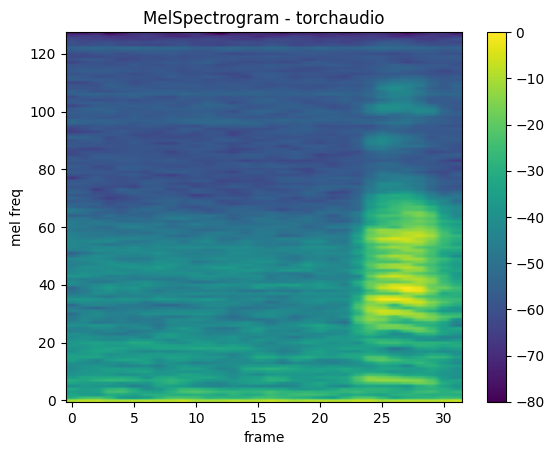

In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SR,
    n_fft = 2048,
    hop_length = 512,
    n_mels = 128
)


train_melspectrogram = SpeechCommandsDataset("/content", subset="training", transformations = mel_spectrogram, device="cpu")
plot_melspectrogram(train_melspectrogram[0][0].squeeze(0).detach().cpu().numpy(), title="MelSpectrogram - torchaudio", ylabel="mel freq")


In [ ]:
drive.mount('/content/drive')

cass_4_GOLD_colabV3.load_state_dict(torch.load("/content/drive/MyDrive/UNIPD_Projects/HumanData/Models/cass_4_GOLD_colabV3_FINETUNE_MEL.pt"))

<All keys matched successfully>

In [ ]:
train_melspectrogram = SpeechCommandsDataset("/content", subset="training", transformations = None, device=device)

In [ ]:
#layer_melspectrogram = MelSpectrogram(sr=SR, trainable_mel=True, trainable_STFT=False).to(device)
layer_melspectrogram = cass_4_GOLD_colabV3.spectrogram
#layer_melspectrogram = layer_melspectrogram.to(device)
b = train_melspectrogram[0][0]

a = layer_melspectrogram(b)

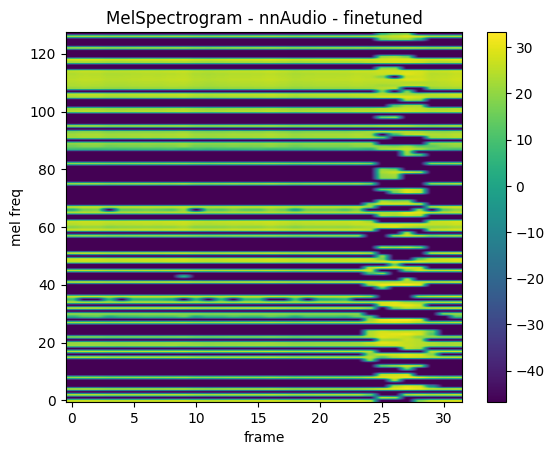

In [ ]:
fine = model_spectrogram(train_melspectrogram[0][0])
plot_melspectrogram(fine.squeeze(0).detach().cpu().numpy(), title="MelSpectrogram - nnAudio - finetuned", ylabel="mel freq")

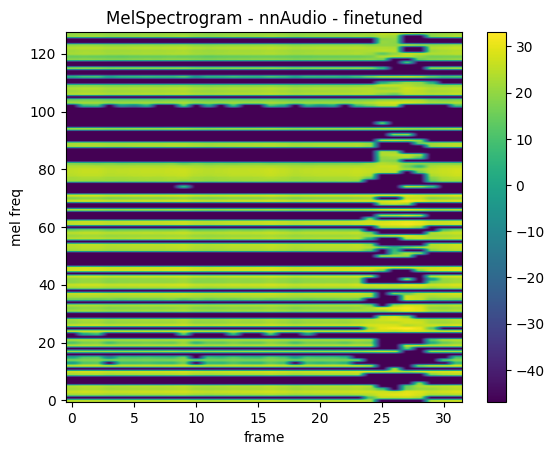

In [ ]:
plot_melspectrogram(a.squeeze(0).detach().cpu().numpy(), title="MelSpectrogram - nnAudio - finetuned", ylabel="mel freq")

STFT kernels created, time used = 0.3070 seconds
STFT filter created, time used = 0.0034 seconds
Mel filter created, time used = 0.0035 seconds


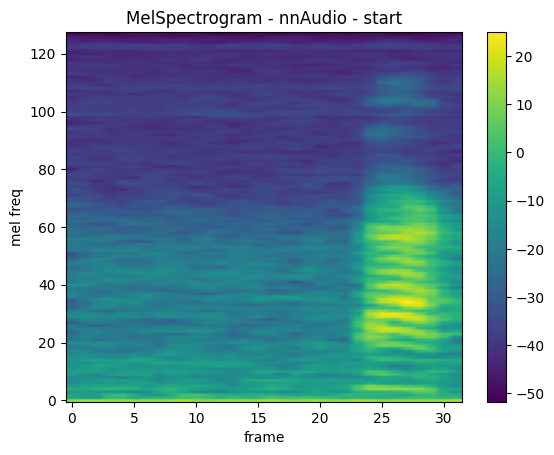

In [ ]:
layer_melspectrogram_clean = MelSpectrogram(sr=SR, trainable_mel=True, trainable_STFT=True).to(device)
a_clean = layer_melspectrogram_clean(b)

plot_melspectrogram(a_clean.squeeze(0).detach().cpu().numpy(), title="MelSpectrogram - nnAudio - start", ylabel="mel freq")

# Fine-Tuning & Pretrained

## Wav2Vec2

In [ ]:
import torchaudio
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

# Load the pre-trained Wav2Vec model and processor
model_name = "facebook/wav2vec2-base-960h"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

model.classifier = nn.Linear(256, 35)

model.to(device)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.weight', 'projector.weight', 'wav2vec2.masked_spec_embed', 'projector.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
train_split = SpeechCommandsDataset_wav2vec("/content", subset="training", transformation = "processor", device=device)
val_split = SpeechCommandsDataset_wav2vec("/content", subset="validation", transformation = "processor", device=device)
test_split = SpeechCommandsDataset_wav2vec("/content", subset="testing", transformation = "processor", device=device)

batch_size = 64

train_loader = DataLoader(train_split, batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size, shuffle=True)
test_loader = DataLoader(test_split, batch_size, shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    model.train()
    for batch in train_loader:
        input_features = batch['input_features'].to(device)
        labels = batch['label']


        # Forward pass
        outputs = model(input_features.squeeze(1))
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions



    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0


    with torch.no_grad():
      for batch in val_loader:
          input_features = batch['input_features'].to(device)
          labels = batch['label']

          # Forward pass
          outputs = model(input_features.squeeze(1))
          logits = outputs.logits

          # Calculate loss
          loss = criterion(logits, labels)

          # Calculate accuracy
          _, predicted_labels = torch.max(logits, dim=1)
          correct_predictions += (predicted_labels == labels).sum().item()
          total_predictions += labels.size(0)

      epoch_accuracy_val = correct_predictions / total_predictions

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{10} - "
          f"Train Accuracy: {epoch_accuracy*100:.2f}%"
          f"Val Accuracy:{epoch_accuracy_val*100:.2f}%")


Epoch 1/10 - Train Accuracy: 72.21%Val Accuracy:95.77%
Epoch 2/10 - Train Accuracy: 84.85%Val Accuracy:96.00%
Epoch 3/10 - Train Accuracy: 84.42%Val Accuracy:95.29%


In [ ]:
model.eval()

with torch.no_grad():
  correct_predictions = 0
  total_predictions = 0
  for batch in test_loader:
      input_features = batch['input_features'].to(device)
      labels = batch['label']

      # Forward pass
      outputs = model(input_features.squeeze(1))
      logits = outputs.logits

      # Calculate accuracy
      _, predicted_labels = torch.max(logits, dim=1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted_labels == labels).sum().item()


  test_acc = 100 * (correct_predictions / total_predictions)

# Print epoch statistics
print('Test set accuracy: {:.2f}%'.format(test_acc))


Test set accuracy: 95.61%


##MobileNetV2, VGG19, ResNet50

In [ ]:
train_split = SpeechCommandsDataset("/content", subset="training", transformations = mel_spectrogram, device=device, whole=False)
val_split = SpeechCommandsDataset("/content", subset="validation", transformations = mel_spectrogram, device=device, whole=False)
test_split = SpeechCommandsDataset("/content", subset="testing", transformations = mel_spectrogram, device=device, whole=False)

batch_size = 128

train_loader = DataLoader(train_split, batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size, shuffle=True)
test_loader = DataLoader(test_split, batch_size, shuffle=True)

In [ ]:
mobilenet = setup_other_models("mobile", True)

optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

tr = fit_and_eval(mobilenet, 30, optimizer, criterion, N_CLASSES_SPEECH, train_loader, val_loader, device, validation_step = True)


mobilenet_w = torch.save(mobilenet.state_dict(), "/content/mobilenet_.pt")
files.download("/content/mobilenet_.p")

In [ ]:
test(mobilenet, device, test_loader)

100%|██████████| 86/86 [00:15<00:00,  5.49it/s]

Test set accuracy: 84.67%


{'Time_test': [15.677255630493164], 'Acc_test': [84.670604270786]}

In [ ]:
resnet50 = setup_other_models("resnet", True)

optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

tr = fit_and_eval(resnet50, 30, optimizer, criterion, N_CLASSES_SPEECH, train_loader, val_loader, device, validation_step = True)


resnet50_w = torch.save(resnet50.state_dict(), "/content/resnet50_pretrained.pt")
files.download("/content/resnet50_pretrained.p")

In [ ]:
vgg19 = setup_other_models("vgg", True)

optimizer = torch.optim.Adam(vgg19.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

tr = fit_and_eval(vgg19, 30, optimizer, criterion, N_CLASSES_SPEECH, train_loader, val_loader, device, validation_step = True)


resnet50_w = torch.save(resnet50.state_dict(), "/content/resnet50_pretrained.pt")
files.download("/content/resnet50_pretrained.p")

In [ ]:
# ------------------------- TEST --------------------------- #

In [ ]:
drive.mount('/content/drive')

shutil.copy("/content/drive/MyDrive/UNIPD_Projects/HumanData/Models/W_Human.rar", "/content/")

!mkdir "/content/Models"

In [ ]:
!unrar x "/content/W_Human.rar" "/content/Models"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/W_Human.rar

Extracting  /content/Models/vgg19_bn_speech_.p                             1%  3%  4%  6%  7%  9% 10% 12% 14% 15% 17% 18% 20% 21% 23% 25% 26% 28% 29% 30%  OK 
Extracting  /content/Models/resnet50_speech_.p                            32% 33% 35% 37% 38% 40% 41% 43% 44% 46% 47% 49% 51% 52% 54% 55% 57% 58% 60% 61%  OK 
Extracting  /content/Models/mobilev2_speech_.p                            63% 64% 65%  OK 
Extracting  /content/Models/resnet50_speech_pretrained.p                  66% 68% 69% 71% 73% 74% 76% 77% 79% 80% 82% 84% 85% 87% 88% 90% 91% 93% 95% 96%  OK 
Extracting  /content/Models/mobilev2_speech_pr

In [ ]:
my_resnet = setup_other_models("resnet", False)
my_vgg = setup_other_models("vgg", False)
my_mobile = setup_other_models("mobile", False)

In [ ]:
load_weights("/content/Models/mobilev2_speech_.p", my_mobile)
load_weights("/content/Models/resnet50_speech_.p", my_resnet)
load_weights("/content/Models/vgg19_bn_speech_.p", my_vgg)

In [ ]:
#def test(model, device, test_loader):
test(my_mobile, device, test_loader)

test(my_resnet, device, test_loader)

test(my_vgg, device, test_loader)